## Connecting with GPU

In [ ]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## Connecting the dataset which is stored in the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# (Part 1)

## Importing the neccessary libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from glob import glob
from scipy.io import loadmat
from IPython.display import Image,display
from PIL import ImageOps,Image
from skimage.color import rgb2gray
from sklearn.cluster import KMeans

###Here am splitting the dataset into training and testing,

90% of the dataset is used for training and the rest is for validation

We have a total of 1250 images in a dataset

In [ ]:
# Create training image dataset path list

training_dir =  '/content/drive/MyDrive/image_segmentation/Training'

num_train_images = round(0.9 * len(glob(os.path.join(training_dir, "Images/*"))))             # We are taking 90% of images for training and keeping 10% for validation
train_images = sorted(glob(os.path.join(training_dir, "Images/*")))[:num_train_images]        # glob function gets the list of files in the directory Training -> Images
train_masks = sorted(glob(os.path.join(training_dir, "Ground_Truth/*")))[:num_train_images]   # glob function gets the list of files in the directory Training -> Ground Truth

print('Number of images for training: {} \n'.format(len(train_images)))
print('Number of images in Ground Truth: {} \n'.format(len(train_masks)))


Number of images for training: 1125 

Number of images in Ground Truth: 1125 



In [ ]:
# Display a sample in training dataset
print('Path of 1st image: {} \n'.format(train_images[0]))
print('Path of 1st mask : {} \n'.format(train_masks[0]))

Path of 1st image: /content/drive/MyDrive/image_segmentation/Training/Images/0001562.jpg 

Path of 1st mask : /content/drive/MyDrive/image_segmentation/Training/Ground_Truth/0001562.png 



In [ ]:
# Create validation image dataset path list

num_val_images = len(glob(os.path.join(training_dir, "Images/*"))) - num_train_images
val_images = sorted(glob(os.path.join(training_dir, "Images/*")))[num_train_images : num_val_images + num_train_images]
val_masks = sorted(glob(os.path.join(training_dir, "Ground_Truth/*")))[num_train_images : num_val_images + num_train_images]

print('Number of images for validation: {} \n'.format(len(val_images)))

print('Total number of images in the dataset: {} \n'.format(num_train_images + num_val_images))

Number of images for validation: 125 

Total number of images in the dataset: 1250 



### First six images present in the training dataset

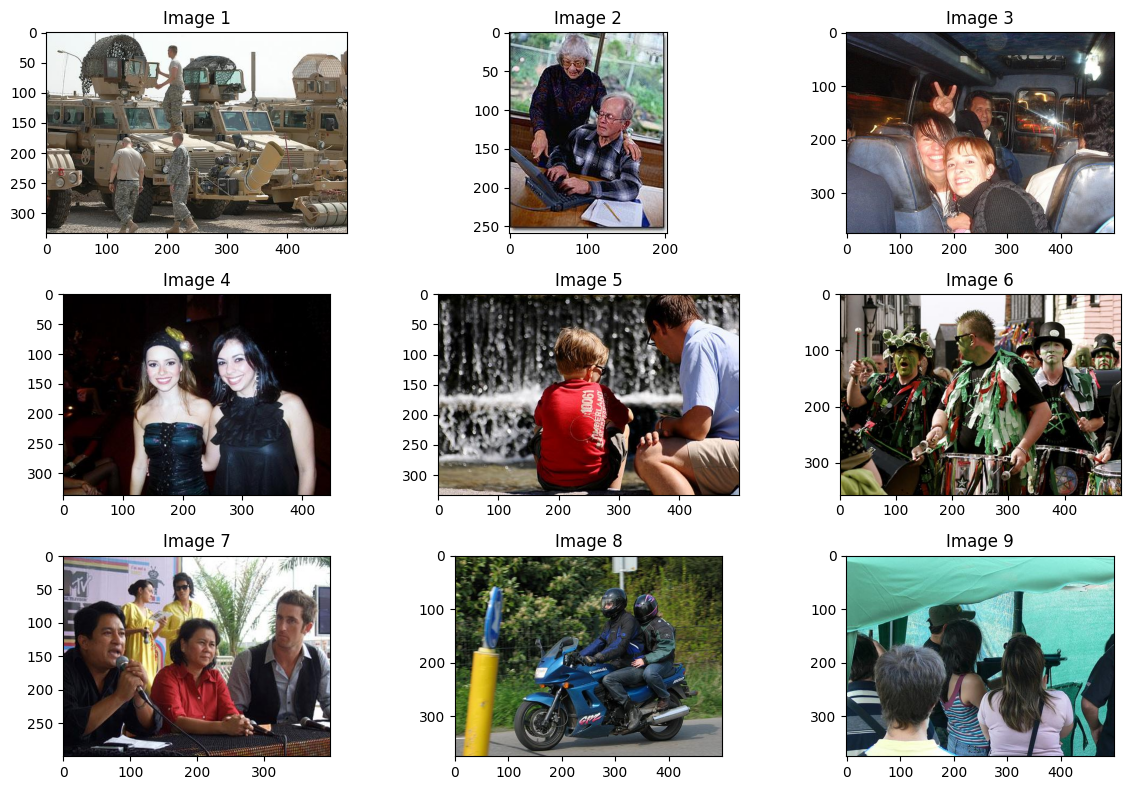

In [ ]:
# Create a figure with a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(train_images):
        image = cv2.imread(train_images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.set_title(f"Image {i + 1}")

# Remove any remaining empty subplots
for i in range(len(train_images), 6):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

###Each respective grid represents the masked images

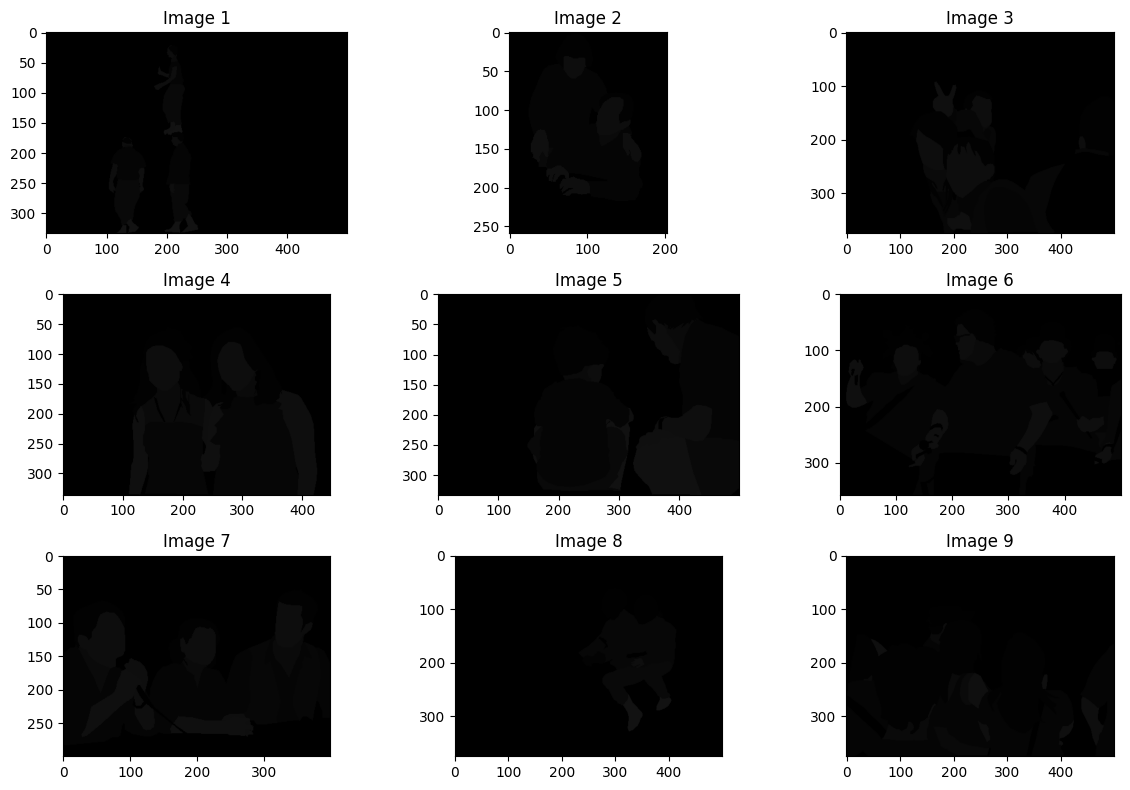

In [ ]:
# Create a figure with a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(train_masks):
        image = cv2.imread(train_masks[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.set_title(f"Image {i + 1}")

# Remove any remaining empty subplots
for i in range(len(train_masks), 6):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

## Edge Detection Methods



### (A) Canny Method

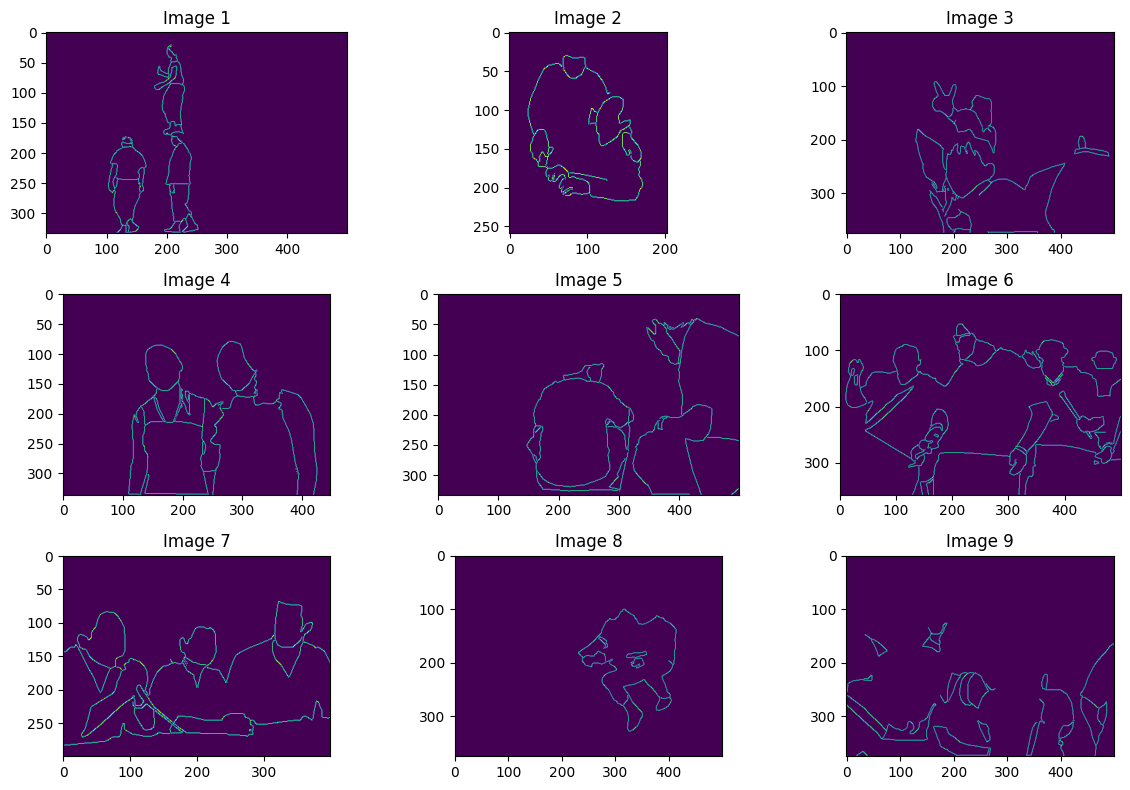

In [ ]:
# Create a figure with a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(train_masks):
        image = cv2.imread(train_masks[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        canny = cv2.Canny(image, 10, 20)
        ax.imshow(canny)
        ax.set_title(f"Image {i + 1}")

# Remove any remaining empty subplots
for i in range(len(train_masks), 6):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### (B) Sobel Method

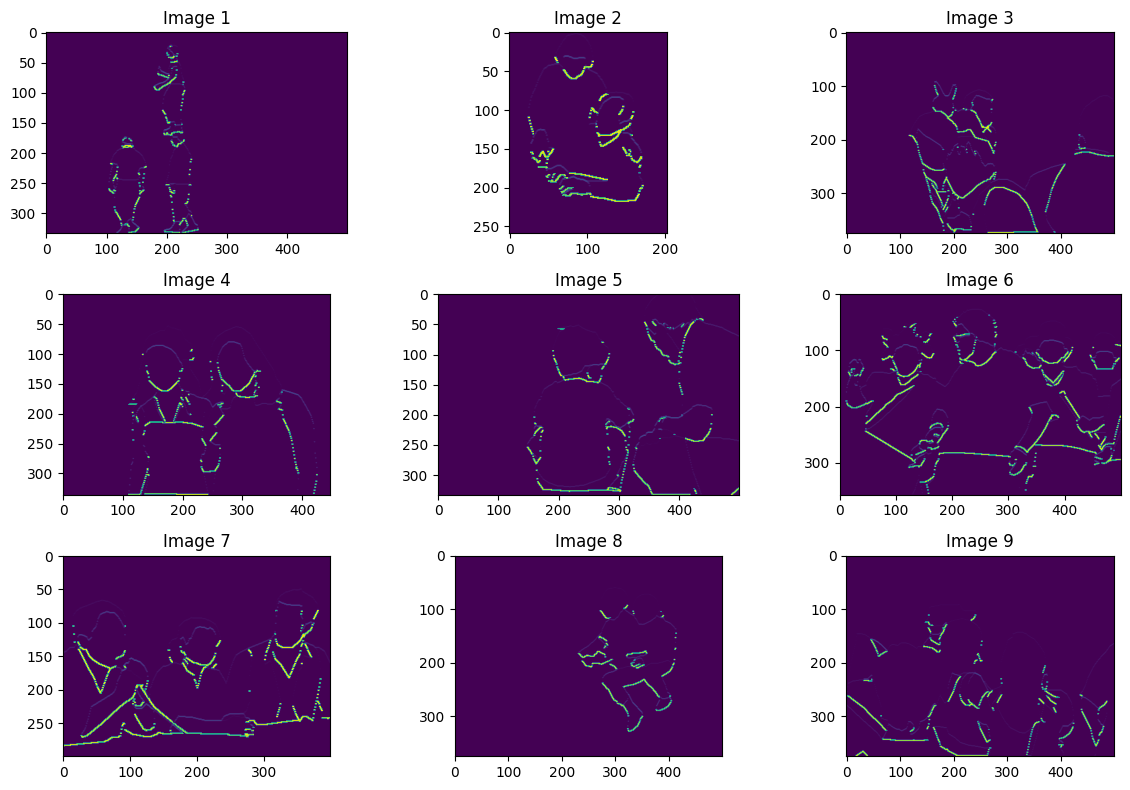

In [ ]:
from scipy import ndimage
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(train_masks):
        image = cv2.imread(train_masks[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sobbel = ndimage.sobel(image, 0)                 # 0 Horizontal|||| 1 Vertical
        ax.imshow(sobbel)
        ax.set_title(f"Image {i + 1}")

# Remove any remaining empty subplots
for i in range(len(train_masks), 6):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# from PIL import ImageOps, Image, ImageEnhance

# # Load the original image
# original_img = Image.open(train_images[2])

# # Apply autocontrast to the image
# # autocontrast_img = ImageOps.autocontrast(original_img)
# equalized_img = ImageOps.autocontrast(original_img)


# # Display the images side by side
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # Display the original image on the left
# axes[0].imshow(original_img)
# axes[0].set_title('Original Image')
# axes[0].axis('off')

# # Display the autocontrast version on the right
# axes[1].imshow(equalized_img)
# axes[1].set_title('Autocontrast Image')
# axes[1].axis('off')

# plt.show()


We want to apply a certain threshold to this image. This threshold should separate the image into two parts – the foreground and the background. We will take the mean of the pixel values and use that as a threshold. If the pixel value is more than our threshold, we can say that it belongs to an object. If the pixel value is less than the threshold, it will be treated as the background.

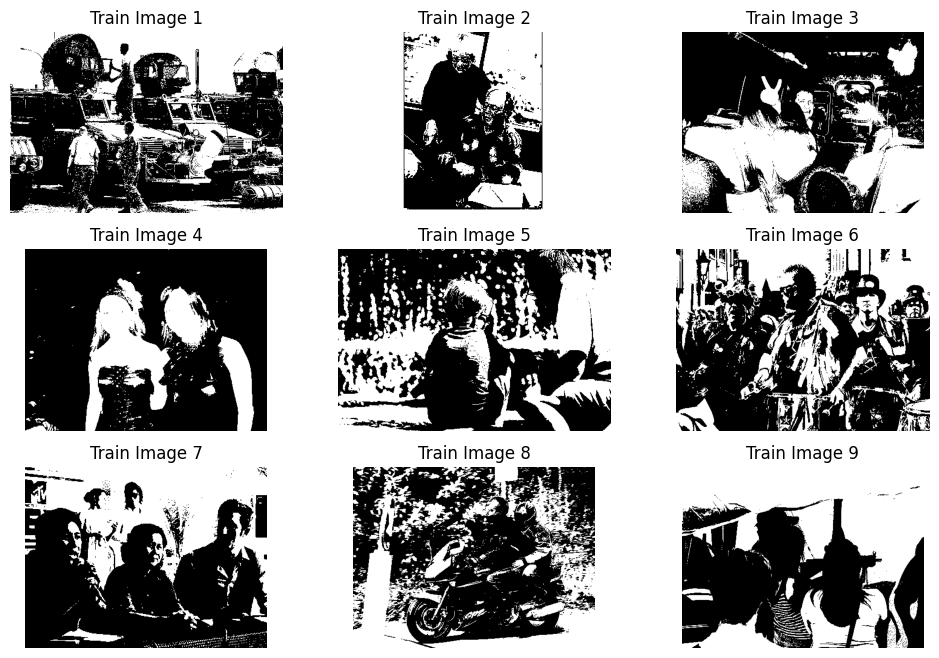

In [ ]:
def binarize_image(image):
    gray = rgb2gray(image)
    gray_r = gray.reshape(gray.shape[0] * gray.shape[1])

    for i in range(gray_r.shape[0]):
        if gray_r[i] > gray_r.mean():
            gray_r[i] = 1
        else:
            gray_r[i] = 0

    binarized_image = gray_r.reshape(gray.shape[0], gray.shape[1])

    return binarized_image


# Print the binarized images for the first 9 images
plt.figure(figsize=(12, 8))

for i, image_path in enumerate(train_images[:9]):
    image = Image.open(image_path)
    binarized_image = binarize_image(np.array(image))

    plt.subplot(3, 3, i + 1)
    plt.imshow(binarized_image, cmap='gray')
    plt.title(f'Train Image {i + 1}')
    plt.axis('off')

plt.show()

# (Part 2)

## K Means Clustering


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

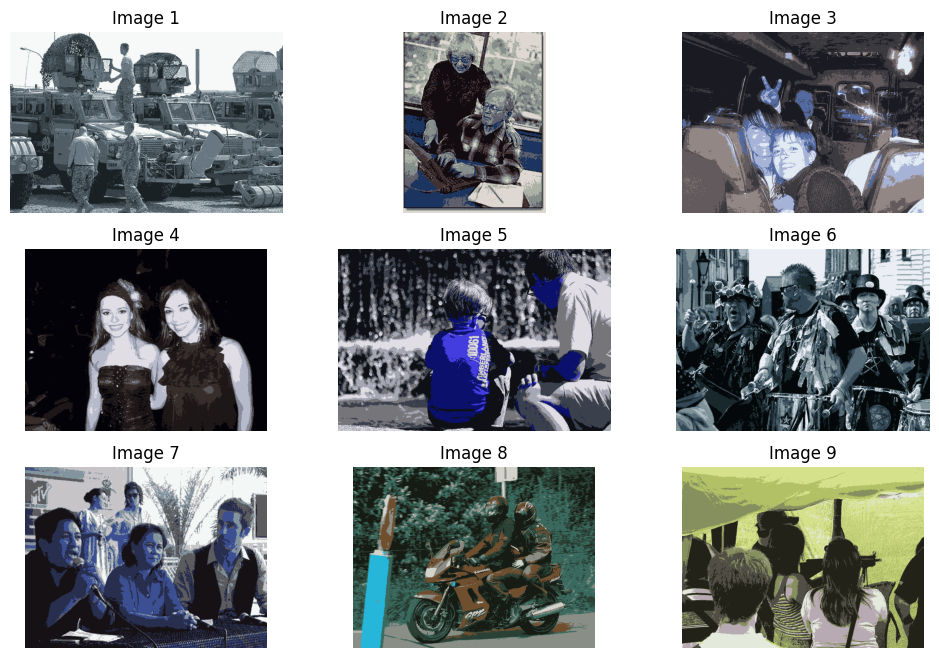

In [ ]:


# Create a single figure for all subplots
plt.figure(figsize=(12, 8))

# Loop through the first 9 images
for i in range(9):
    # Read the image
    image = cv2.imread(train_images[i])

    # Normalize pixel values to be between 0 and 1
    image = image / 255.0

    # Reshape the image to 2D
    pic_n = image.reshape(image.shape[0] * image.shape[1], image.shape[2])        # 0 is the height, 1 is the width and 2 is the channel

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=7, random_state=0).fit(pic_n)
    pic2show = kmeans.cluster_centers_[kmeans.labels_]        # choosing the center points
    cluster_pic = pic2show.reshape(image.shape[0], image.shape[1], image.shape[2])    # reshaping back to 3D

    # Plot the original and clustered images in subplots
    plt.subplot(3, 3, i + 1)
    plt.imshow(cluster_pic)
    plt.title(f"Image {i + 1}")
    plt.axis("off")

# Show the figure with all subplots
plt.show()


### Using customed ResNet50 architecture

In [ ]:
BATCH_SIZE = 4
IMAGE_SIZE = 512

def read_image(image_path,mask=False):
  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image,channels = 1) #it is set to 1, indicating that the decoded image should have a single channel. This suggests that the image is expected to be a grayscale image
    image.set_shape([None,None,1])
    image = tf.image.resize(images = image,size=[IMAGE_SIZE,IMAGE_SIZE])
  else:
    image = tf.image.decode_png(image,channels = 3) #it is set to 3,this suggests that the image is expected to be a RGB image
    image.set_shape([None,None,3])
    image = tf.image.resize(images = image,size=[IMAGE_SIZE,IMAGE_SIZE])
    image = image/127.5 -1   #Normalising image
  return image

def load_data(image_list,mask_list):
  image = read_image(image_list)
  mask = read_image(mask_list,mask = True)
  return image,mask

def data_generator(image_list,mask_list):   #accessing images and masks
  dataset = tf.data.Dataset.from_tensor_slices((image_list,mask_list))
  dataset = dataset.map(load_data,num_parallel_calls=tf.data.AUTOTUNE)    # making it efficient for training or processing large datasets.
  dataset = dataset.batch(BATCH_SIZE,drop_remainder = True)
  return dataset

train_dataset =  data_generator(train_images,train_masks)
print("Number of batches in Training: {} \n ".format(len(train_dataset)))

val_dataset = data_generator(val_images,val_masks)
print("Number of batches in Validation: {} \n ".format(len(val_dataset)))

Number of batches in Training: 281 
 
Number of batches in Validation: 31 
 


## Model Architecture

### A regular convolution as looking at one pixel at a time, while dilated convolution allows the filter to skip some pixels and gather information from a larger context

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,           # dilation_rate - allowing it to capture information from a broader area.
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [ ]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)     # dspp_input undergoes averagepooling
    x = convolution_block(x, kernel_size=1, use_bias=True)                      # performing a dilated convolution operation
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)
  # UpSampling2D increases the spatial resolution of the input tensor
  #After this line, out_pool represents the tensor obtained by upsampling the tensor x to match the
  ##spatial dimensions of the original input tensor dspp_input.

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


## We are using ResNet50 architecture

### We are  removing the last layer of ResNet and making a custom layer of Dilated convolution and Spatial Pooling to achieve best performance

###Dilated Convolution:

*   In dilated convolution, the filter has gaps between its elements
*   This allows the filter to "see" a larger area of the input without increasing its size
### Spatial Pooling
*   It helps simplify the information and reduce the spatial size(h,w,c)

Both dilated convolution and spatial pooling are techniques used in convolutional neural networks to enhance the network's ability to understand and represent complex patterns in images.





In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))        #input layer
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input     # weights are trained on imagenet dataset
    )

    # featuring a layar from ResNet and applying (DilatedSpatialPyramidPooling)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)                           # spatial pooling


    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)   # Dilated convolution

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

NUM_CLASSES = 20    # label each pixel in an image with a category or class
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

## Visualizing the Model Architecture

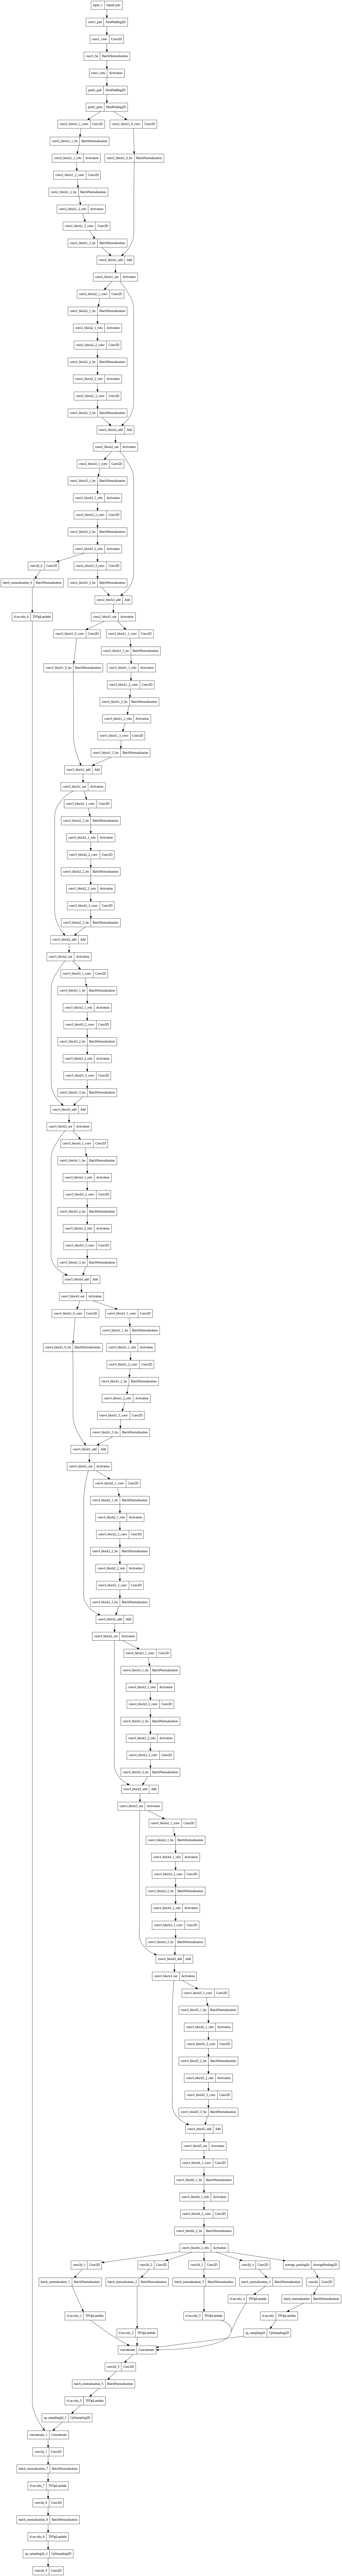

In [ ]:
plot_model(model,to_file='model.png')

### Compiling the model



*   Loss function : it will measure how close the prediction values are to the target value

*   SparseCategoricalCrossentropy is the loss function when there are 2 or more classes are present, "True" means softmax activation function are used in the output layer

*   Adam Optimizer is used to find the best solution efficiently by adjusting step sizes



In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits =True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss = loss, metrics=["accuracy"],)

## EarlyStopping
### In order to avoid overfitting


*   we are basically monitoring the validation dataset
*   mode = min, minimize the monitored metric,training will stop when the quantity being monitored stops decreasing


*   patience = 20, meaning the if validation loss does not decrease for 20 consecutive epochs, training will stop early





In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss',mode = 'min',verbose = 1, patience = 20)


In [ ]:
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/image_segmentation/segment_weights.h5",
                               monitor='val_loss',
                               mode='min',
                               verbose=1,
                               save_best_only=True)

## Training the model

In [ ]:
# Training the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[checkpointer, earlystopping])

Epoch 1/25
160/281 [================>.............] - ETA: 1:07:26 - loss: 1.3448 - accuracy: 0.6093